In [82]:
# Import library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from warnings import filterwarnings
filterwarnings('ignore')

Load Dataset

In [83]:
%%time
sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')

train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)


(590540, 433)
(506691, 432)
CPU times: user 45.1 s, sys: 34.5 s, total: 1min 19s
Wall time: 1min 26s


In [84]:
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
for f in X_test.columns:
    if X_test[f].dtype=='object':
        lbl.fit(list(X_test[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [85]:
# Prepare data to SMOTE method
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)

In [86]:
# Split the dataset
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.2,
                                                 random_state=42)

Train XGBoost model

In [87]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2021,
    tree_method='hist'
)

In [88]:
%time clf.fit(x_train, y_train)

CPU times: user 13min 59s, sys: 24.4 s, total: 14min 24s
Wall time: 2min 23s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2021, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', validate_parameters=1, verbosity=None)

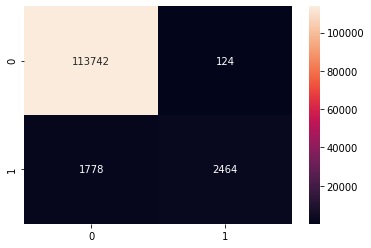

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.95      0.58      0.72      4242

    accuracy                           0.98    118108
   macro avg       0.97      0.79      0.86    118108
weighted avg       0.98      0.98      0.98    118108



In [89]:
# Evaluate model
cm = confusion_matrix(y_val, clf.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, clf.predict(x_val)))

Train Decision tree model

In [90]:
dct = DecisionTreeClassifier()
%time dct.fit(x_train, y_train)

CPU times: user 2min 18s, sys: 5.05 s, total: 2min 23s
Wall time: 2min 25s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

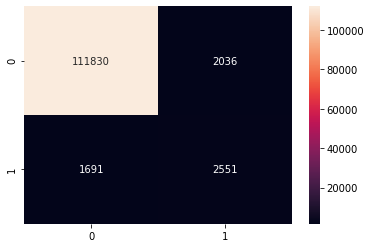

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    113866
           1       0.56      0.60      0.58      4242

    accuracy                           0.97    118108
   macro avg       0.77      0.79      0.78    118108
weighted avg       0.97      0.97      0.97    118108



In [91]:
# Evaluate the decision tree model
cm = confusion_matrix(y_val, dct.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, dct.predict(x_val)))

Build random forest model

In [92]:
#Hyper param tuned
rf = RandomForestClassifier(max_depth=45, max_features=45, n_estimators=500, n_jobs=-1, min_samples_leaf=100)
%time rf.fit(x_train, y_train) 

CPU times: user 2h 6min 59s, sys: 1min 6s, total: 2h 8min 6s
Wall time: 19min 58s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features=45,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

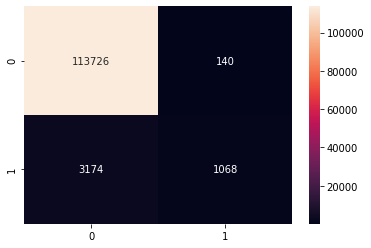

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    113866
           1       0.88      0.25      0.39      4242

    accuracy                           0.97    118108
   macro avg       0.93      0.63      0.69    118108
weighted avg       0.97      0.97      0.96    118108



In [93]:
cm = confusion_matrix(y_val, rf.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, rf.predict(x_val)))

Train Logistic regression model

In [94]:
lr = LogisticRegression()
%time lr.fit(x_train, y_train)

CPU times: user 2min 10s, sys: 6.24 s, total: 2min 16s
Wall time: 40.9 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

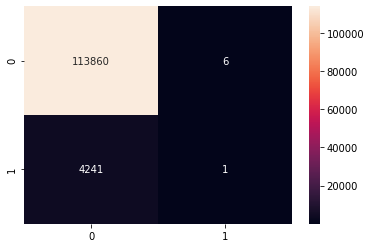

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    113866
           1       0.14      0.00      0.00      4242

    accuracy                           0.96    118108
   macro avg       0.55      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108



In [95]:
# Evaluate the model
cm = confusion_matrix(y_val, lr.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, lr.predict(x_val)))

Apply SMOTE method for imbalance dataset

In [96]:
x_train, x_val, y_train, y_val = train_test_split(X_smote, y_smote,
                                                 test_size=0.2,
                                                 random_state=42)

Train XGBoost model with SMOTE data

In [97]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2021,
    tree_method='hist'
)
%time clf.fit(x_train, y_train)

CPU times: user 30min 22s, sys: 42.9 s, total: 31min 5s
Wall time: 4min 43s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2021, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', validate_parameters=1, verbosity=None)

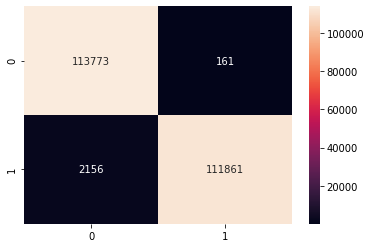

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113934
           1       1.00      0.98      0.99    114017

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951



In [98]:
# Evaluate model
cm = confusion_matrix(y_val, clf.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, clf.predict(x_val)))

Train Decision tree model with SMOTE data

In [99]:
dct = DecisionTreeClassifier()
%time dct.fit(x_train, y_train)

CPU times: user 6min 26s, sys: 11.9 s, total: 6min 37s
Wall time: 6min 41s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

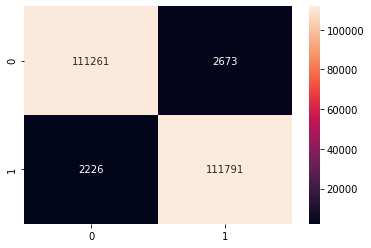

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113934
           1       0.98      0.98      0.98    114017

    accuracy                           0.98    227951
   macro avg       0.98      0.98      0.98    227951
weighted avg       0.98      0.98      0.98    227951



In [100]:
# Evaluate the decision tree model
cm = confusion_matrix(y_val, dct.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, dct.predict(x_val)))

Build random forest model with SMOTE data

In [101]:
#Hyper param tuned
rf = RandomForestClassifier(max_depth=45, max_features=45, n_estimators=500, n_jobs=-1, min_samples_leaf=100)
%time rf.fit(x_train, y_train) 

CPU times: user 5h 1min 21s, sys: 1min 37s, total: 5h 2min 58s
Wall time: 40min 17s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features=45,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

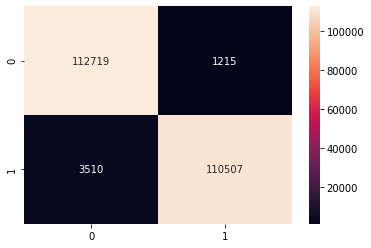

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    113934
           1       0.99      0.97      0.98    114017

    accuracy                           0.98    227951
   macro avg       0.98      0.98      0.98    227951
weighted avg       0.98      0.98      0.98    227951



In [102]:
cm = confusion_matrix(y_val, rf.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, rf.predict(x_val)))

Train Logistic regression model with SMOTE data

In [103]:
lr = LogisticRegression()
%time lr.fit(x_train, y_train)

CPU times: user 3min 20s, sys: 15.5 s, total: 3min 35s
Wall time: 1min 11s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

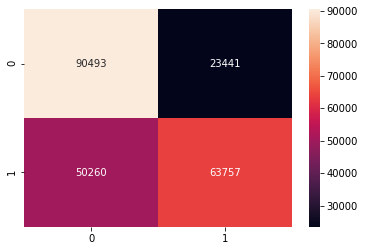

              precision    recall  f1-score   support

           0       0.64      0.79      0.71    113934
           1       0.73      0.56      0.63    114017

    accuracy                           0.68    227951
   macro avg       0.69      0.68      0.67    227951
weighted avg       0.69      0.68      0.67    227951



In [104]:
# Evaluate the model
cm = confusion_matrix(y_val, lr.predict(x_val))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()
print(classification_report(y_val, lr.predict(x_val)))

Submission

In [105]:
# Using XGBoost model with SMOTE method result to submission
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('fraud-detection-submission_XGB.csv')